In [12]:
import pandas as pd
import shap
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from hyperopt import STATUS_OK
from hyperopt import tpe
from hyperopt import hp
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB

In [13]:
df = pd.read_csv('C:\\Users\\...\\dataset.csv')

In [14]:
df = df.drop('BMI_CAT', axis =1)

In [15]:
df = df.drop('Unnamed: 0', axis=1)

In [16]:
df

,ANEMIA,ASTHMA,CIG_NOW,DIABETES,GESTATIONAL_AGE,GESTATIONAL_AGE_CAT,HIGHBP_NOTPREG,HIGHBP_PREECLAMPSIA,KIDNEY,MOM_INSURANCE,MOM_PIDX,VAGINOSIS
0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,b00014490,0.0
1,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,b00028364,0.0
2,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,b00048093,0.0
3,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,b00060642,0.0
4,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,b00096696,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7863,1.0,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,3381,0.0
7864,0.0,NaN,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,3382,0.0
7865,0.0,NaN,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,3383,0.0
7866,0.0,NaN,1.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,3384,0.0


### Downsampling to balance my classes

In [17]:
y = df1.GESTATIONAL_AGE_CAT
X = df1.drop('GESTATIONAL_AGE_CAT', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [18]:
# concatenate our training data back together
B = pd.concat([X_train, y_train], axis=1)

In [19]:
# separate minority and majority classes
nopreterm = B[B.GESTATIONAL_AGE_CAT==0]
preterm = B[B.GESTATIONAL_AGE_CAT==1]

In [20]:
# downsample majority
nopreterm_downsampled = resample(nopreterm,
                                replace = False, # sample without replacement
                                n_samples = len(preterm), # match minority n
                                random_state = 27) # reproducible results

In [21]:
# combine minority and downsampled majority
df_down = pd.concat([nopreterm_downsampled, preterm])

In [22]:
df_down.to_csv('C:\\Users\\kimam\\Desktop\\Insight\\Data\\Combined_final\\downsample.csv')

In [23]:
# checking counts
df_down.GESTATIONAL_AGE_CAT.value_counts()

1.0    1062
0.0    1062
Name: GESTATIONAL_AGE_CAT, dtype: int64

### Upsampling to balance my dataset

In [24]:
# Splitting the dataset into the Training set and Test set
#from sklearn.cross_validation import train_test_split
y = df1.GESTATIONAL_AGE_CAT
X = df1.drop('GESTATIONAL_AGE_CAT', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [25]:
# concatenate our training data back together
A = pd.concat([X_train, y_train], axis=1)

In [26]:
# separate minority and majority classes
nopreterm = A[A.GESTATIONAL_AGE_CAT==0]
preterm = A[A.GESTATIONAL_AGE_CAT==1]

In [27]:
# upsample minority
preterm_upsampled = resample(preterm,
                          replace=True, # sample with replacement
                          n_samples=len(nopreterm), # match number in majority class
                          random_state=10) # reproducible results


In [28]:
# combine majority and upsampled minority
df_up = pd.concat([nopreterm, preterm_upsampled])

In [29]:
df_up.GESTATIONAL_AGE_CAT.value_counts()

1.0    4204
0.0    4204
Name: GESTATIONAL_AGE_CAT, dtype: int64

#### Since I tried fitting the models both with the up and undersampled dataframes with no difference,
I chose to stick with the downsampled dataframe (hopefully less bias).

# Model fitting

### LightGBM

In [30]:
#the first two commands are for the upsampled data, the second ones for the downsampled one
#y_train = df_up.GESTATIONAL_AGE_CAT
#X_train = df_up.drop('GESTATIONAL_AGE_CAT', axis=1)
y_train = df_down.GESTATIONAL_AGE_CAT
X_train = df_down.drop('GESTATIONAL_AGE_CAT', axis=1)

In [31]:
X_train

,ANEMIA,ASTHMA,CIG_NOW,DIABETES,HIGHBP_NOTPREG,HIGHBP_PREECLAMPSIA,KIDNEY,MOM_INSURANCE,VAGINOSIS
3760,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3005,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6159,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5951,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [32]:
####This is the output of the hyperparameter tuning.
####I left it here in case I need it later after making additional changes.
#Training until validation scores don't improve for 30 rounds
#Early stopping, best iteration is:
#[44]	valid's auc: 0.615275	valid's binary_logloss: 0.669674
#Best score reached: 0.5696836847946726 with params: {'colsample_bytree': 0.7567653721452665, 'min_child_samples': 113, 'min_child_weight': 10.0, 'num_leaves': 21, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.8058026565741467} 

In [65]:
#Model 2
#This is the second algorithm, after hyperparameter tuning. The initial training and fitting are below
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'recall'
params['sub_feature'] = 0.5
params['num_leaves'] = 18
params['min_data'] = 50
params['max_depth'] = 10
params['usemissing'] = False
params['min_child_samples'] = 113
params['colsample_bytree'] = 0.7567653721452665
params['min_child_weight'] = 10
params['reg_alpha'] = 0.1
params['reg_lambda'] = 5
params['subsample'] = 0.8058026565741467
params['scale_pos_weight']= 1
#params['is_unbalance'] = True

clf2 = lgb.train(params, d_train, 100)

In [66]:
#This is the pickle command needed to store the model for the project app
#pkl_filename = 'clf2.pkl'
#with open(pkl_filename,'wb') as file:
    #pickle.dump(clf2,file)

In [67]:
#Prediction (make predictions on trained lgbm on the actual test set)
pred=clf2.predict(X_test)

In [68]:
pred

array([0.51192871, 0.48317638, 0.51874452, ..., 0.48317638, 0.48441253,
       0.49228456])

In [69]:
#convert into binary values
for i in range(0,1756):
    if pred[i]>=.5:       # setting threshold to .5
       pred[i]=1
    else:  
       pred[i]=0

In [70]:
pred

array([1., 0., 1., ..., 0., 0., 0.])

In [71]:
#Confusion matrix
#from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred.round())
cm

array([[982, 406],
       [179, 189]], dtype=int64)

<Figure size 432x288 with 0 Axes>

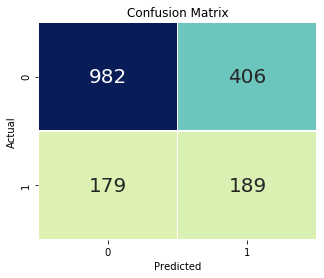

In [72]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plt.figure()
cm = confusion_matrix(y_test, pred.round())
plt.figure(figsize=(5,4))
hcm=sns.heatmap(cm, annot = True,annot_kws={"size": 20}, fmt='d', cmap="YlGnBu", vmin = 0.3,linewidths=.5, cbar = False);
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
(hcm).get_figure().savefig('heat_cm.png')
plt.show()

In [73]:
print('Accuracy score: ', accuracy_score(y_test, pred.round()))
print('Precision score: ', precision_score(y_test, pred.round()))
print('Recall score: ', recall_score(y_test, pred.round()))

Accuracy score:  0.6668564920273349
Precision score:  0.3176470588235294
Recall score:  0.5135869565217391


### Assess the performance of the model

In [74]:
print(classification_report(y_test, pred.round()))


              precision    recall  f1-score   support

         0.0       0.85      0.71      0.77      1388
         1.0       0.32      0.51      0.39       368

    accuracy                           0.67      1756
   macro avg       0.58      0.61      0.58      1756
weighted avg       0.74      0.67      0.69      1756



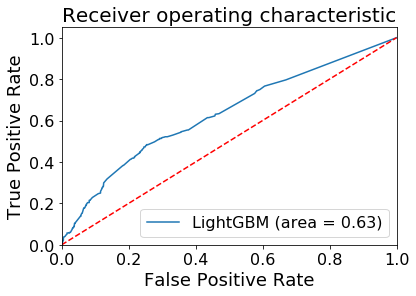

In [75]:
#calculate ROC and make a graph
lgbm_roc_auc = roc_auc_score(y_test, clf2.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf2.predict(X_test)[:1756])
plt.figure()
plt.plot(fpr, tpr, label='LightGBM (area = %0.2f)' % lgbm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Receiver operating characteristic',fontsize=20)
plt.legend(loc="lower right", fontsize =16)
plt.savefig('lgbm_ROC')
plt.show()

In [76]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
average_precision = average_precision_score(y_test, pred.round())

Precision is a measure of how often your predictions for the positive class are actually true. It’s calculated as the number of True Positives (e.g. predicting preterm labor risk and it is actually preterm labor risk) over the sum of the True Positives and False Positives (e.g. predicting preterm labor risk when there isn't). High precision relates to low false positive rate.

Recall (sensitivity) is the measure of how often the actual positive class is predicted as such. It’s calculated as the number of True Positives over the sum of the True Positives and False Negatives (e.g. predicting no preterm labor risk when there is).
Of all the preterm labor that are truly preterms, how many did we label? 

Hence, a situation of low precision emerges when very few of your positive predictions are true (predicted as preterm labor when it wasn't), and low recall occurs if most of your positive values are never predicted (when preterm labor is rarely predicted in general).

In [77]:
print('Average precision-recall score RF: {}'.format(average_precision))

Average precision-recall score RF: 0.2650756048680738


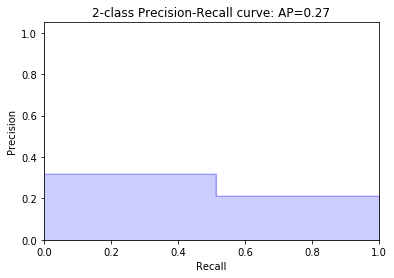

In [78]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.savefig('pre_recall_lgbm')

### Now I will use Shap to gain insights from my model 

To understand why a certain prediction is made

In [79]:
# load JS visualization code to notebook
shap.initjs()

In [80]:
X_train

,Anemia,Asthma,Smoking,Diabetes,Hypertension,Preeclampsia,Urinary tract infections,Insurance,Vaginosis
3760,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3005,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6159,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5951,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [81]:
X_train.rename(columns={'CIG_NOW':'Smoking',
                          'DIABETES':'Diabetes',
                          'HIGHBP_NOTPREG':'Hypertension', 'ASTHMA':'Asthma','ANEMIA':'Anemia','HIGHBP_PREECLAMPSIA':'Preeclampsia','KIDNEY':'Urinary tract infections','VAGINOSIS':'Vaginosis','MOM_INSURANCE':'Insurance'}, 
                 inplace=True)

In [82]:
X_train

,Anemia,Asthma,Smoking,Diabetes,Hypertension,Preeclampsia,Urinary tract infections,Insurance,Vaginosis
3760,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3005,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
3612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6159,0.0,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5951,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [83]:
explainer = shap.TreeExplainer(clf2)
shap_values = explainer.shap_values(X, y=y.values)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [84]:
shap_values = shap.TreeExplainer(clf2).shap_values(X_train)

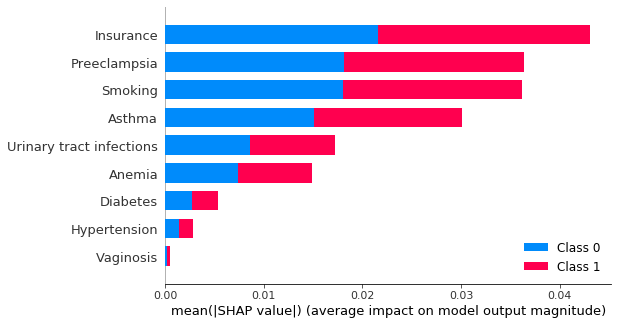

In [85]:
shap.summary_plot(shap_values, X_train, plot_type="bar",show=False)
#get_figure().savefig('shap_summary.png')
plt.savefig('shap_sum.png')

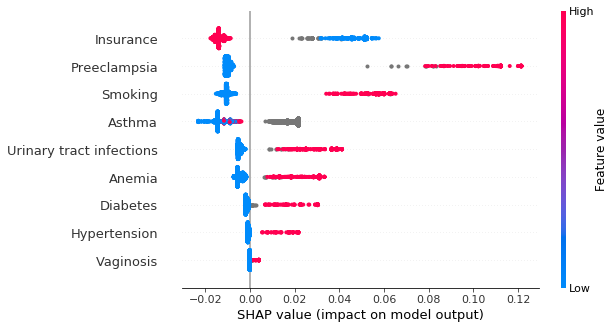

In [86]:
shap.summary_plot(shap_values[1], X_train,show=False)
plt.savefig('shap_fp.png')

It appears that whether a pregnant woman is insured, has high blood pressure/preeclampsia or is a smoker highly influences the probability of preterm labor in the model.

In [87]:
# plot the SHAP values for the 1st observation 
#shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])
shap.force_plot(explainer.expected_value[1], shap_values[1])

#### Not the best performance ever but given the data I had access to and the difficult classification task, I'm satified!

### Hyperparameter tuning

Here are the steps between fitting model 1 and final model 2

#### The original model (all the above code is after hyperparameter tuning)

In [56]:
# MODEL 1
#import lightgbm as lgb
#start training the algorithm on the prediction
#d_train = lgb.Dataset(X_train, label=y_train)
#params = {}
#params['learning_rate'] = 0.003
#params['boosting_type'] = 'gbdt'
#params['objective'] = 'binary'
#params['metric'] = 'binary_logloss'
#params['sub_feature'] = 0.5
#params['num_leaves'] = 10
#params['min_data'] = 50
#params['max_depth'] = 10
#params['usemissing'] = False
#params['is_unbalance'] = True
#params['scale_pos_weight'] = 1
#clf = lgb.train(params, d_train, 100)

In [57]:
#Prediction
#y_pred=clf.predict(X_test)
#convert into binary values
#for i in range(0,99):
    #if y_pred[i]>=.5:       # setting threshold to .5
       #y_pred[i]=1
    #else:  
       #y_pred[i]=0

In [58]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [59]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'recall', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [60]:
#from scipy.stats import randint as sp_randint
#from scipy.stats import uniform as sp_uniform
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'learning_rate':[1e-3, 1e-4],
            }

In [61]:
gs = RandomizedSearchCV(lgb.LGBMClassifier(), param_test, cv=5, n_jobs = -1, n_iter=1000)

In [62]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Training until validation scores don't improve for 30 rounds
[100]	valid's binary_logloss: 0.664439
Did not meet early stopping. Best iteration is:
[75]	valid's binary_logloss: 0.664249
Best score reached: 0.5701542730299667 with params: {'colsample_bytree': 0.4580862938480331, 'learning_rate': 0.0001, 'min_child_samples': 131, 'min_child_weight': 0.001, 'num_leaves': 6, 'reg_alpha': 2, 'reg_lambda': 20, 'subsample': 0.5586681951501777} 


In [63]:
model_y3=gs.predict(X_test)

In [64]:
print(classification_report(y_test, model_y3.round()))

              precision    recall  f1-score   support

         0.0       0.84      0.68      0.75      1388
         1.0       0.30      0.53      0.38       368

    accuracy                           0.64      1756
   macro avg       0.57      0.60      0.57      1756
weighted avg       0.73      0.64      0.67      1756

